# Recency, Frequency and Monetary Analysis on H&M Data

## 1 Import libraries

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy import stats

## 2 Data pre-processing for RFM
- Check variables
- Derive Recency, Frequency and Monetary variables

### 2.1 Read in CSV and Conduct Basic Analysis

In [2]:
# Read in CSV
df = pd.read_csv('data/transactions_train.csv')
print('Dataframe shape:',df.shape)
print('Columns:',list(df.columns))
df.head()

Dataframe shape: (31788324, 5)
Columns: ['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id']


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [3]:
# Basic data check: Check for null values
for col in df.columns:
    print("Number of Null Values in", col, " : ", len(df[df[col].isna()]), "/", len(df))

Number of Null Values in t_dat  :  0 / 31788324
Number of Null Values in customer_id  :  0 / 31788324
Number of Null Values in article_id  :  0 / 31788324
Number of Null Values in price  :  0 / 31788324
Number of Null Values in sales_channel_id  :  0 / 31788324


In [4]:
# Basic data check: Check data types
df.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [5]:
# Change data type
df = df.astype({'t_dat':'datetime64[ns]',
                'customer_id':'str',
                'article_id':'str',
                'price':'float',
                'sales_channel_id':'str'})
df.dtypes

t_dat               datetime64[ns]
customer_id                 object
article_id                  object
price                      float64
sales_channel_id            object
dtype: object

In [6]:
# Subset relevant columns and 
# Change order of dataframe to place customer_id at the front
cols = ['customer_id','t_dat','price','article_id']
df_new = df[cols]
df_new.head()

,customer_id,t_dat,price,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.050831,663713001
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.030492,541518023
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.015237,505221004
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.016932,685687003
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.016932,685687004


### 2.2 Create dataframe for RFM analysis

#### Check number of unique customers

In [7]:
# Check number of unique customers
len(df['customer_id'].unique())

1362281

#### Recency

In [8]:
# Subset dataset to get customer_id and t_dat to compute recency
df_recency = df_new.loc[:,['customer_id','t_dat']]
print(len(df_recency) == len(df)) # check
# df_recency.head()

True


In [9]:
print(df_recency['t_dat'].max())

2020-09-22 00:00:00


In [10]:
# Get last date of purchase
df_recency = pd.DataFrame(df_recency.groupby('customer_id')['t_dat'].max()).reset_index()
print(len(df_recency) == len(df_new['customer_id'].unique()))
# df_recency.head()

True


In [11]:
# Calculate recency based on 2020-10-01
date = dt.datetime(2020, 10, 1)
df_recency['Recency'] = df_recency.t_dat.apply(lambda x:(date - x).days)
df_recency.head()

,customer_id,t_dat,Recency
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2020-09-05,26
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2020-07-08,85
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2020-09-15,16
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,2019-06-09,480
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2020-08-12,50


#### Frequency

In [12]:
# Subset dataset to get customer_id and t_dat to compute frequency
df_frequency = df_new.loc[:,['customer_id','t_dat']]
print(len(df_frequency) == len(df)) # check
# df_frequency.head()

True


In [13]:
# Calculate frequency based on total number of purchases
df_frequency = pd.DataFrame(df_frequency.groupby('customer_id')['t_dat'].count()).reset_index()
print(len(df_frequency) == len(df_new['customer_id'].unique()))
df_frequency.columns = ['customer_id', 'Frequency']
df_frequency.head()

True


,customer_id,Frequency
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,21
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,86
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,18
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,2
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,13


#### Monetary

In [14]:
# Subset dataset to get customer_id and price to compute monetary
df_monetary = df_new.loc[:,['customer_id','price']]
print(len(df_monetary) == len(df)) # check
# df_monetary.head()

True


In [15]:
# Calculate monetary based on average amount spent per transaction
df_monetary = pd.DataFrame(df_monetary.groupby('customer_id')['price'].mean()).reset_index()
print(len(df_monetary) == len(df_new['customer_id'].unique()))
df_monetary.columns = ['customer_id', 'Monetary']
df_monetary.head()

True


,customer_id,Monetary
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.030904
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.030255
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.039154
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.030492
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0.036130


## 3 RFM analysis
https://github.com/klaudia-nazarko/rfm-analysis-python/blob/master/rfm_analysis_python.ipynb

### 3.1 Combine RFM into a single dataframe
- `Recency`: Number of days from latest transaction date to 2020-10-1 (because the latest t_dat in dataset is 2020-9-22 so chose 2020-10-1 as a reasonable benchmark)
- `Frequency`: Number of transactions per customer_id
- `Money`: Average spending per transaction

In [16]:
df_rfm = pd.merge(df_recency, df_frequency, on='customer_id')
df_rfm = pd.merge(df_rfm, df_monetary, on='customer_id')
df_rfm = df_rfm.drop(['t_dat'], axis=1)
print('Dataframe shape:',df_rfm.shape)
df_rfm.head()

Dataframe shape: (1362281, 4)


,customer_id,Recency,Frequency,Monetary
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,21,0.030904
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,85,86,0.030255
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,18,0.039154
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,480,2,0.030492
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,13,0.036130


### 3.2 Conduct RFM Analysis by grouping customers into segments
- Recency: (shortened interval because shopping for clothes is a necessity)
    - Active: Purchase within past 6 months
    - Warm: Purchase within past 12 months / 1 month
    - Cold: Purchase within past 2 years
    - Lost: Purchase beyond past 2 years
- Frequency:
    - Occasional: Bottom 30% quantile
    - Average: Middle 30% quantile
    - Frequent: Top 30% quantile
- Monetary:
    - Top 20%: Valuable
    - Bottom 80%: Less valuable

In [17]:
# assign recency label
bins = [0,6*30,12*30,24*30,1000]

r_labels = ['Active','Warm','Cold','Lost']
df_rfm['r_label'] = pd.cut(df_rfm['Recency'], bins=bins, labels=r_labels, right=False)

# r_scores = [4,3,2,1]
# df_rfm['r_score'] = pd.cut(df_rfm['Recency'], bins=bins, labels=r_scores, right=False).astype(int)

In [18]:
# assign frequency label
f_labels = ['Occasional','Average','Frequent']
df_rfm['f_label'] = pd.qcut(df_rfm['Frequency'], q=3, labels=f_labels)

# f_scores = [1,2,3]
# df_rfm['f_score'] = pd.qcut(df_rfm['Frequency'], q=3, labels=f_scores).astype(int)

In [19]:
# assign monetary label
bins = [0, np.percentile(df_rfm.Monetary,20), 1]

m_labels = ['Bottom 80%','Top 20%']
df_rfm['m_label'] = pd.cut(df_rfm['Monetary'], bins=bins, labels=m_labels, right=False)

# m_scores = [2,1]
# df_rfm['m_score'] = pd.cut(df_rfm['Monetary'], bins=bins, labels=m_scores, right=False).astype(int)

In [20]:
# Add a column to sum rfm scores
# df_rfm['rfm_sum'] = df_rfm['r_score'] + df_rfm['f_score'] + df_rfm['m_score']
df_rfm.head()

,customer_id,Recency,Frequency,Monetary,r_label,f_label,m_label
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,21,0.030904,Active,Frequent,Top 20%
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,85,86,0.030255,Active,Frequent,Top 20%
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,18,0.039154,Active,Average,Top 20%
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,480,2,0.030492,Cold,Occasional,Top 20%
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,13,0.036130,Active,Average,Top 20%


#### RFM Customer Segments
- Champions: Highest recency, frequency and monetary
- Loyal: High recency and monetary
- Valuable: High monetary
- New active: High recency and frequency but monetary may not be high
- New: High recency and low frequency or High recency and low monetary
- Average: Does not show any specific traits especially
- Potential re-activation: Able to spend
- Needs attention: Low recency, but able to spend
- At risk: Low recency and monetary but frequency not lowest

- Lost: Lowest recency, frequency and monetary

In [21]:
def assign_label(df, r_label, f_label, m_label, label, colname='rfm_label'):
    df.loc[(df['r_label']==r_label) & (df['f_label']==f_label)
              & (df['m_label']==m_label), colname] = label
    return df

# def assign_label(df, r_rule, f_rule, m_rule, label, colname='rfm_label'):
#     df.loc[(df['r_score'].between(r_rule[0], r_rule[1]))
#             & (df['f_score'].between(f_rule[0], f_rule[1]))
#             & (df['m_score'].between(m_rule[0], m_rule[1])), colname] = label
#     return df

In [22]:
df_rfm['rfm_label'] = ''

df_rfm = assign_label(df_rfm, 'Active', 'Frequent', 'Top 20%', 'Champions')
df_rfm = assign_label(df_rfm, 'Active', 'Average', 'Top 20%', 'Loyal')
df_rfm = assign_label(df_rfm, 'Active', 'Occasional', 'Top 20%', 'Valuable')
df_rfm = assign_label(df_rfm, 'Active', 'Frequent', 'Bottom 80%', 'New active')
df_rfm = assign_label(df_rfm, 'Active', 'Average', 'Bottom 80%', 'New')
df_rfm = assign_label(df_rfm, 'Active', 'Occasional', 'Bottom 80%', 'New')

df_rfm = assign_label(df_rfm, 'Warm', 'Frequent', 'Top 20%', 'Loyal')
df_rfm = assign_label(df_rfm, 'Warm', 'Average', 'Top 20%', 'Valuable')
df_rfm = assign_label(df_rfm, 'Warm', 'Occasional', 'Top 20%', 'Valuable')
df_rfm = assign_label(df_rfm, 'Warm', 'Frequent', 'Bottom 80%', 'Average')
df_rfm = assign_label(df_rfm, 'Warm', 'Average', 'Bottom 80%', 'Average')
df_rfm = assign_label(df_rfm, 'Warm', 'Occasional', 'Bottom 80%', 'Average')

df_rfm = assign_label(df_rfm, 'Cold', 'Frequent', 'Top 20%', 'Potential re-activation')
df_rfm = assign_label(df_rfm, 'Cold', 'Average', 'Top 20%', 'Potential re-activation')
df_rfm = assign_label(df_rfm, 'Cold', 'Occasional', 'Top 20%', 'Needs attention')
df_rfm = assign_label(df_rfm, 'Cold', 'Frequent', 'Bottom 80%', 'Needs attention')
df_rfm = assign_label(df_rfm, 'Cold', 'Average', 'Bottom 80%', 'At risk')
df_rfm = assign_label(df_rfm, 'Cold', 'Occasional', 'Bottom 80%', 'At risk')

df_rfm = assign_label(df_rfm, 'Lost', 'Frequent', 'Top 20%', 'Lost')
df_rfm = assign_label(df_rfm, 'Lost', 'Average', 'Top 20%', 'Lost')
df_rfm = assign_label(df_rfm, 'Lost', 'Occasional', 'Top 20%', 'Lost')
df_rfm = assign_label(df_rfm, 'Lost', 'Frequent', 'Bottom 80%', 'Lost')
df_rfm = assign_label(df_rfm, 'Lost', 'Average', 'Bottom 80%', 'Lost')
df_rfm = assign_label(df_rfm, 'Lost', 'Occasional', 'Bottom 80%', 'Lost')

In [23]:
print('Dataframe shape:',df_rfm.shape)
df_rfm.head()

Dataframe shape: (1362281, 8)


,customer_id,Recency,Frequency,Monetary,r_label,f_label,m_label,rfm_label
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,21,0.030904,Active,Frequent,Top 20%,Champions
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,85,86,0.030255,Active,Frequent,Top 20%,Champions
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,18,0.039154,Active,Average,Top 20%,Loyal
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,480,2,0.030492,Cold,Occasional,Top 20%,Needs attention
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,13,0.036130,Active,Average,Top 20%,Loyal


## 3.3 RFM Segment Analysis

### 3.3.1 General Analysis on RFM Segments

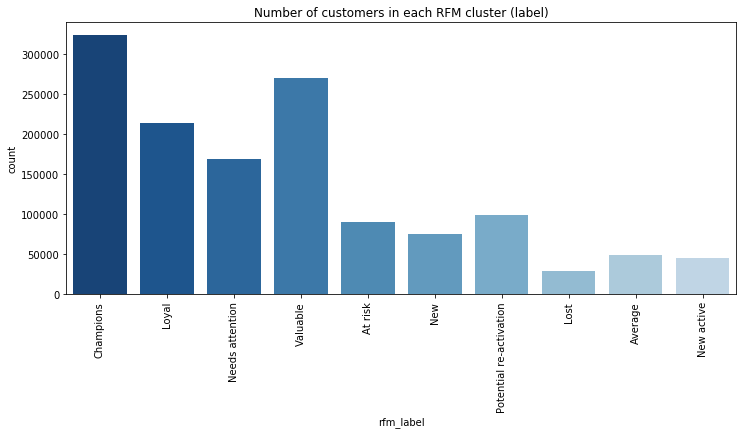

In [24]:
palette = sns.color_palette("Blues_r", n_colors=13)

for rfm_type in ['label']:
    fig, ax = plt.subplots(figsize=(12,5))
    sns.countplot(x='rfm_'+rfm_type, data=df_rfm, palette=palette)
    ax.set_title('Number of customers in each RFM cluster (%s)' % rfm_type)
    if rfm_type == 'label':
        plt.xticks(rotation=90)
    plt.show()

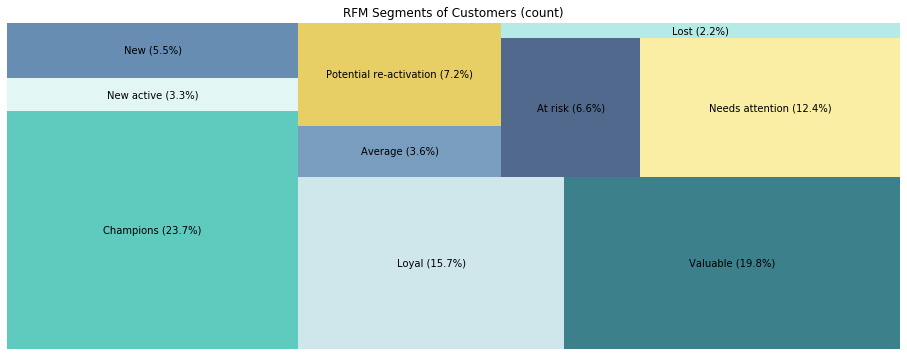

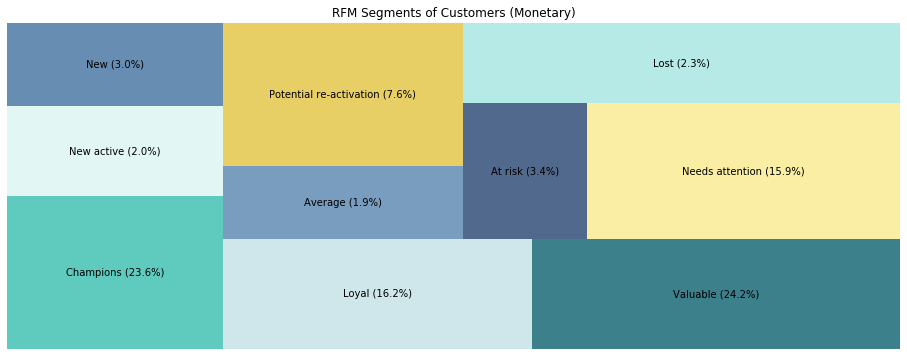

In [25]:
import squarify
agg_dict2 = {
    'customer_id': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'sum'
}

df_analysis = df_rfm.groupby('rfm_label').agg(agg_dict2).sort_values(by='Recency').reset_index()
df_analysis.rename({'rfm_label': 'label', 'customer_id': 'count'}, axis=1, inplace=True)
df_analysis['count_share'] = df_analysis['count'] / df_analysis['count'].sum()
df_analysis['Monetary_share'] = df_analysis['Monetary'] / df_analysis['Monetary'].sum()
df_analysis['Monetary'] = df_analysis['Monetary'] / df_analysis['count']

colors = ['#37BEB0', '#DBF5F0', '#41729F', '#C3E0E5', '#0C6170', '#5885AF', '#E1C340', '#274472', '#F8EA8C', '#A4E5E0', '#1848A0']

for col in ['count', 'Monetary']:
    labels = df_analysis['label'] + df_analysis[col + '_share'].apply(lambda x: ' ({0:.1f}%)'.format(x*100))

    fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=df_analysis[col], label=labels, alpha=.8, color=colors)
    ax.set_title('RFM Segments of Customers (%s)' % col)
    plt.axis('off')
    plt.show()

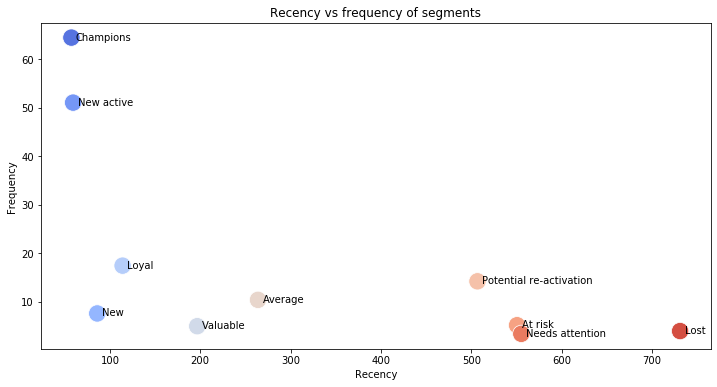

In [26]:
palette = sns.color_palette("coolwarm", 10)

fig, ax = plt.subplots(figsize=(12,6))
plot = sns.scatterplot(x='Recency', y='Frequency', data=df_analysis, hue='label', s=300, palette=palette)

for i in range(len(df_analysis)):
     plot.text(df_analysis['Recency'][i]+5,
               df_analysis['Frequency'][i]-0.5,
               df_analysis['label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Recency vs frequency of segments')
ax.get_legend().remove()
plt.show()

### 3.3.2 Demographic Analysis of RFM Segments

In [45]:
customers = pd.read_csv('data/customers.csv')
print('Dataframe shape:',customers.shape)
customers.head()

Dataframe shape: (1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [46]:
customers = customers.loc[:,['customer_id','Active','club_member_status','fashion_news_frequency','age','postal_code']]
rfm_customers = customers.merge(df_rfm[['customer_id','rfm_label']], on='customer_id')
print('Dataframe shape:',rfm_customers.shape)
rfm_customers.head()

Dataframe shape: (1362281, 7)


,customer_id,Active,club_member_status,fashion_news_frequency,age,postal_code,rfm_label
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,Champions
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,Champions
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,Loyal
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,Needs attention
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,Loyal
